In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, absolute_import, division

In [3]:
from copy import deepcopy
import numpy as np
from HeuristicPolicy import HeuristicGomokuPolicy, ThreatSearch
from GomokuBoard import GomokuBoard
from GomokuTools import GomokuTools as gt
from Heuristics import Heuristics, won_or_lost
from UCT_Search import UCT_Node, PolicyAdapter, GomokuEnvironment, GomokuState

In [4]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

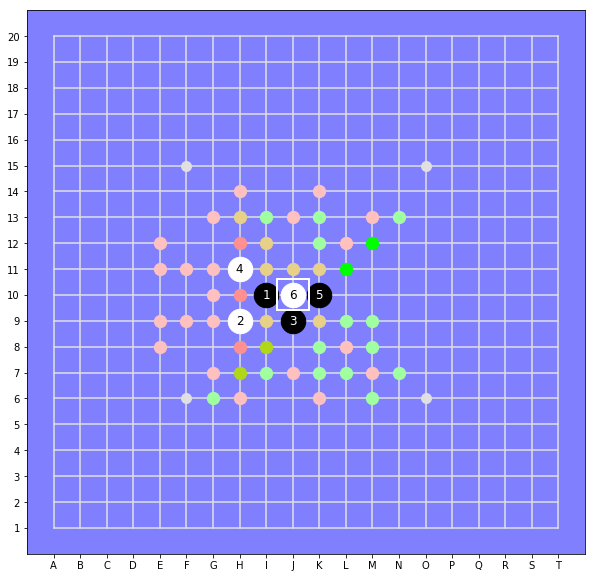

In [5]:
h = Heuristics(kappa=3.0)
board = GomokuBoard(h, N=20, disp_width=10)
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5, threat_search=ThreatSearch(2,2))
board.set(I,10).set(H,9).set(J,9).set(H,11).set(K,10).set(J,10)
board.display('current');

In [6]:
p.suggest(board)

Style: 2: (H, 13)

In [7]:
stones = [(G,8), (F,7), (H,7), (F,9), (I,8), (H,8)]
env = GomokuEnvironment(heuristic=h, N=15, disp_width=6, initial_stones=stones)

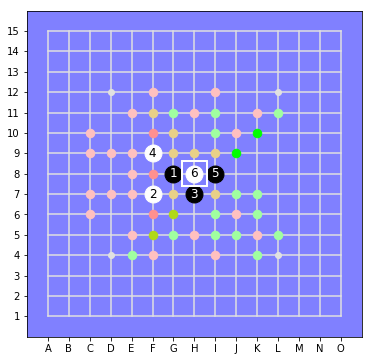

In [8]:
state=env.reset()
board = GomokuBoard(heuristics=h, N=15, disp_width=6, stones=state.stones)
board.display('current')

---

# UCT Step by step

In [9]:
from UCT_Search import uct_search, UCT_Node

({(6, 8): 0.23175966670010778,
  (6, 11): 0.001566784591589664,
  (7, 6): 0.0006907528046498051,
  (9, 7): 0.15671202475314278,
  (9, 9): 0.60927077115051},
 -0.025250766210376696)

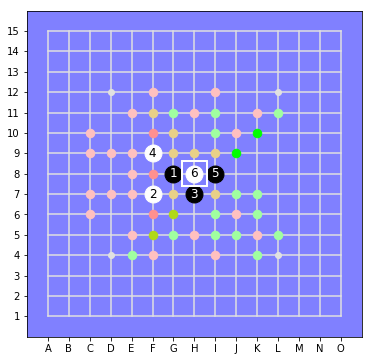

In [37]:
observation=env.reset()
board = GomokuBoard(heuristics=h, N=observation.size, disp_width=6, stones=observation.stones)
strong_policy = HeuristicGomokuPolicy(style = 2, bias=.8, topn=5  
                                      #,threat_search=ThreatSearch(2,2)
                                     )
strong_policy = PolicyAdapter(strong_policy, h)
fast_policy = PolicyAdapter(HeuristicGomokuPolicy(style=2, bias=1.0, topn=5), h)
board.display('current');
distr, value = fast_policy.evaluate(observation)
distr, value

In [38]:
root = UCT_Node(observation)
root

Path: [None]

### Select

In [39]:
leaf = root.select_leaf()
leaf

Path: [None]

In [40]:
leaf_priors, value_estimate = strong_policy.evaluate(leaf.game_state)

In [41]:
leaf_priors, value_estimate

({(6, 8): 0.0008761514989721001,
  (6, 11): 0.06005232216941857,
  (7, 10): 3.621012523932545e-05,
  (9, 7): 0.9315048764425236,
  (9, 9): 0.007530439763846542},
 -0.025250766210376696)

In [42]:
priors = leaf_priors

In [43]:
def _choose_from(distr):
    action_distr = np.rollaxis(np.array([[i[0], i[1]] for i in distr.items()]), -1, 0)
    actions = action_distr[0]
    probas = list(action_distr[1])
    return np.random.choice(actions, 1, p=probas)[0]

In [44]:
move = _choose_from(priors)
print(move)
obs, reward, terminal, info = env.step(move)
priors, value_estimate = fast_policy.evaluate(obs)
value = won_or_lost(env.board)
priors, value_estimate, value

(9, 7)


({(6, 5): 0.009244626869637416,
  (7, 6): 0.01857048404867106,
  (9, 6): 0.0021802673775869167,
  (10, 7): 0.04730334498280969,
  (10, 9): 0.9227012767212949},
 -0.2010983169215217,
 0)

### Rollout

In [45]:
def rollout(env, priors, num_rollouts = 10, max_depth = 10 ):
    rollout_env = deepcopy(env)

    rollout_counter = 0
    sum_values = 0
    depth = 0
    while rollout_counter < num_rollouts:
        while not won_or_lost(rollout_env.board) and depth < max_depth:
            move = _choose_from(priors)
            state, reward, terminal, info = rollout_env.step(move)
            priors, value_estimate = fast_policy.evaluate(state)
            value = won_or_lost(rollout_env.board)
            depth += 1
        rollout_counter += 1
        sum_values += (value if value else value_estimate)

    avg_value = sum_values / num_rollouts
    return avg_value

avg_value = rollout(env, priors)
print(avg_value)


-0.029208304131372535


### Backup and expand

In [46]:
leaf.expand(leaf_priors)
leaf.backup(avg_value)

In [47]:
root.child_Q()

array([0., 0., 0., 0., 0.])

### The full algorithm

In [50]:
observation=env.reset()
root = UCT_Node(observation)

for i in range(500):
    leaf = root.select_leaf()
    #print("evaluating strong policy...")
    leaf_priors, _ = strong_policy.evaluate(leaf.game_state)
    #print("done.")
    #print("rollout...")
    avg_value = rollout(env, leaf_priors, num_rollouts=4, max_depth=5)
    #print("done.")    
    leaf.expand(leaf_priors)
    leaf.backup(avg_value)

In [51]:
root.child_number_visits

array([103.,  97.,  96., 100.,  98.], dtype=float32)

In [32]:
leaf.number_visits

0.0

In [33]:
leaf.child_Q()

array([0., 0., 0., 0., 0.])

In [25]:
leaf.child_U()

array([0., 0., 0., 0., 0.])

In [26]:
leaf.number_visits

0

In [27]:
leaf.is_expanded

True

In [28]:
leaf.children

{(6, 8): Path: [None, (6, 8)],
 (6, 11): Path: [None, (6, 11)],
 (7, 10): Path: [None, (7, 10)],
 (9, 7): Path: [None, (9, 7)],
 (9, 9): Path: [None, (9, 9)]}